In [305]:
# Uncomment the following if you first started, but comment out after soy you don't have to install every time
# %pip install pandas
# %pip install scikit-learn

In [306]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_recall_curve, auc, confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LinearRegression

In [307]:
# Download the dataset from kaggle - "https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data"
# This will read the csv file if its in your folder, or you can use the full path to the file
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [308]:
# Drop insufficient and uneeded data ("id", "gender - other")
df.drop(columns=["id"], inplace=True)
df.drop(df[df["gender"] == "Other"].index, inplace=True)

In [309]:
imputer = KNNImputer(n_neighbors=5)
df['bmi'] = imputer.fit_transform(df[['bmi', 'age', 'avg_glucose_level']])[:, 0]
df['bmi_age_ratio'] = df['bmi'] / df['age']
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_age_ratio
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,0.546269
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.38,never smoked,1,0.514426
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,0.406250
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,0.702041
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,0.303797


In [310]:
def age_group(age):
        if age < 13:
            return "child"
        elif age < 20:
            return "teen"
        elif age < 35:
            return "young_adult"
        elif age < 55:
            return "middle_aged"
        elif age < 75:
            return "senior"
        else:
            return "elderly"

df["age_group"] = df["age"].apply(lambda x: age_group(x))
df.drop(columns=["age"], inplace=True)

In [311]:
features = ["hypertension", "heart_disease", "stroke", "bmi_age_ratio"]
categorical_features = ["smoking_status", "work_type", "ever_married", "Residence_type", "gender", "age_group"]
numerical_features = ["avg_glucose_level", "bmi"] # add bmi later after linear regression model

# Preprocess the data
# 1. ignore changing "features" in the dataset
# 2. Convert cateogorical features to one-hot encoding to make the model use numeric values
# 3. Scale the numerical features to make numbers closer and scale the data
preprocess = make_column_transformer(
    ("passthrough", features), 
    (OneHotEncoder(sparse_output=False), categorical_features),
    (StandardScaler(), numerical_features),
)

In [312]:
preprocess.fit(df)
df_transformed = preprocess.transform(df)
df = pd.DataFrame(
    data = df_transformed,
    columns = features + preprocess.named_transformers_["onehotencoder"].get_feature_names_out().tolist() + numerical_features,
    index = df.index
)
df.head()

,hypertension,heart_disease,stroke,bmi_age_ratio,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,...,gender_Female,gender_Male,age_group_child,age_group_elderly,age_group_middle_aged,age_group_senior,age_group_teen,age_group_young_adult,avg_glucose_level,bmi
0,0.0,1.0,1.0,0.546269,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.706450,0.985867
1,0.0,0.0,1.0,0.514426,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.121652,0.313618
2,0.0,1.0,1.0,0.406250,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.004867,0.457855
3,0.0,0.0,1.0,0.702041,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.437473,0.702544
4,1.0,0.0,1.0,0.303797,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.501297,-0.636804


In [313]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42, class_weight="balanced")

train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['stroke'], random_state=42)
X_train = train_set.drop(columns=['stroke'])
y_train = train_set['stroke']

X_test = test_set.drop(columns=['stroke'])
y_test = test_set['stroke']

In [314]:
rf.fit(X_train, y_train)
y_probs = rf.predict_proba(X_test)[:, 1]
threshold = 0.6
y_pred = (y_probs > threshold).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()
print("Accuracy:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       972
         1.0       0.19      0.68      0.30        50

    accuracy                           0.84      1022
   macro avg       0.59      0.77      0.61      1022
weighted avg       0.94      0.84      0.88      1022

[[828 144]
 [ 16  34]]

Accuracy: 0.68
Precision: 0.19101123595505617
Recall: 0.68


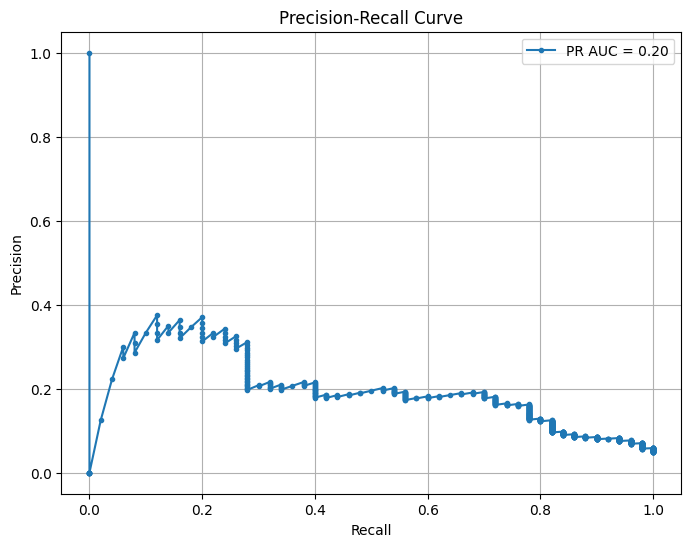

In [315]:
y_probs = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Compute AUC-PR score
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

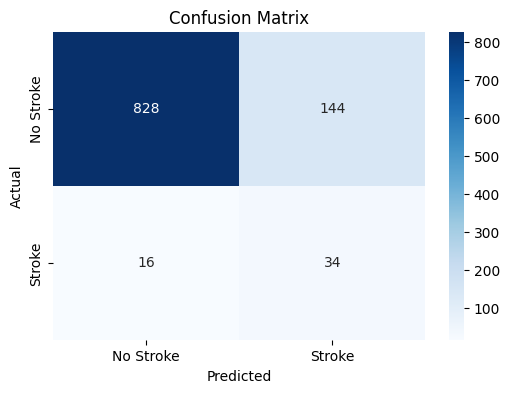

In [316]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()